# Распознавание твитов на тему катастроф

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avk22\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avk22\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('datasets/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print(f'Total entries: {data.shape[0]}')
print(f'NaN`s in keyword: {data.keyword.isna().sum()}')
print(f'NaN`s in location: {data.location.isna().sum()}')

Total entries: 7613
NaN`s in keyword: 61
NaN`s in location: 2533


In [4]:
data_text_only = data[['text', 'target']]
data_text_only.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.drop(columns = ['id'], inplace=True)
data.dropna(subset=['keyword'], inplace=True)
data.head()

,keyword,location,text,target
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


#### Реализую вспомогающую функцию для токенизации, удаления стоп-слов и окончаний

In [6]:
stop = stopwords.words('english')
snowball = SnowballStemmer(language='english')

def tokenize(sentence:str, remove_stopwords:bool = True):
    tokens = nltk.word_tokenize(sentence, language='english')
    #Удаляем знаки препинания
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stopwords:
        tokens = [i for i in tokens if i not in stop]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [7]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize(x, remove_stopwords=True), lowercase=False)

### Создаем пайплайн и обучаем только на тексте

In [40]:
X1_train, X1_test, y1_train, y1_test = train_test_split(data_text_only.text, data_text_only.target)

#С удалением стоп слов
model_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize(x, remove_stopwords=True))),
    ('model', MultinomialNB())
])
model_2 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize(x, remove_stopwords=True))),
    ('model', SVC())
])
#Без удаления стоп слов
model_3 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize(x, remove_stopwords=False))),
    ('model', MultinomialNB())
])
model_4 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize(x, remove_stopwords=False))),
    ('model', SVC())
])

In [44]:
#fitting
model_1.fit(X1_train, y1_train)
model_2.fit(X1_train, y1_train)
model_3.fit(X1_train, y1_train)
model_4.fit(X1_train, y1_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001CD415778B0>)),
                ('model', SVC())])

In [45]:
pred_m1 = model_1.predict(X1_test)
pred_m2 = model_2.predict(X1_test)
pred_m3 = model_3.predict(X1_test)
pred_m4 = model_4.predict(X1_test)
score1 = metrics.f1_score(y1_test, pred_m1)
score2 = metrics.f1_score(y1_test, pred_m2)
score3 = metrics.f1_score(y1_test, pred_m3)
score4 = metrics.f1_score(y1_test, pred_m4)
print(f'model 1: {score1}')
print(f'model 2: {score2}')
print(f'model 3: {score3}')
print(f'model 4: {score4}')

model 1: 0.720619282195637
model 2: 0.7327001356852104
model 3: 0.7025454545454546
model 4: 0.7581521739130435


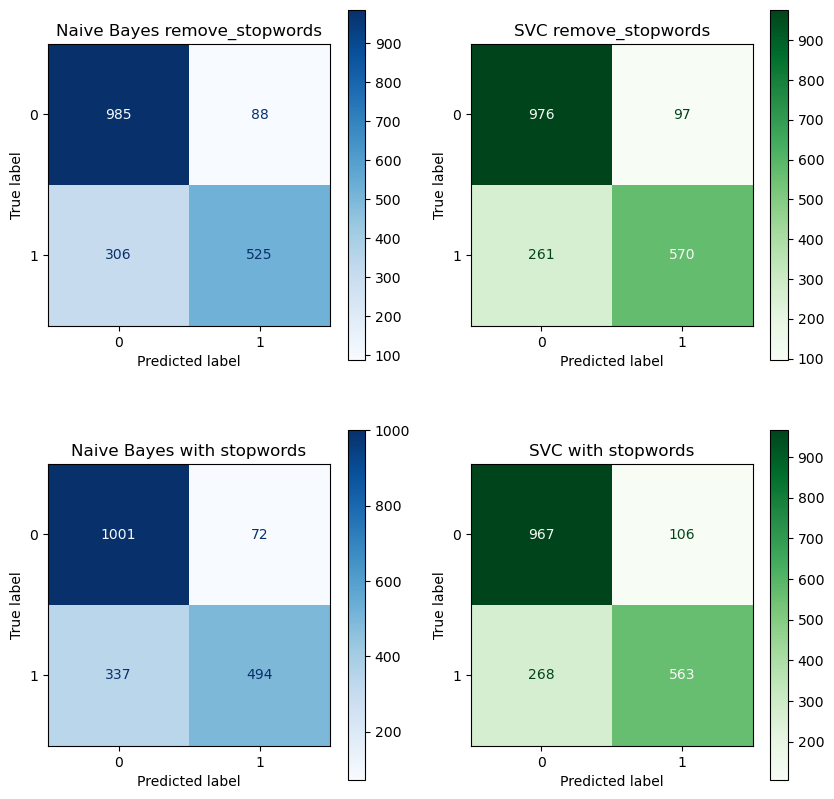

In [15]:
fig, axs = plt.subplots(2,2)
metrics.ConfusionMatrixDisplay.from_predictions(y1_test, pred_m1, display_labels=[0,1], cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_title('Naive Bayes remove_stopwords')
metrics.ConfusionMatrixDisplay.from_predictions(y1_test, pred_m2, display_labels=[0,1], cmap='Greens', ax=axs[0, 1])
axs[0, 1].set_title('SVC remove_stopwords')

metrics.ConfusionMatrixDisplay.from_predictions(y1_test, pred_m3, display_labels=[0,1], cmap='Blues', ax=axs[1, 0])
axs[1, 0].set_title('Naive Bayes with stopwords')
metrics.ConfusionMatrixDisplay.from_predictions(y1_test, pred_m4, display_labels=[0,1], cmap='Greens', ax=axs[1, 1])
axs[1, 1].set_title('SVC with stopwords')

fig.set_figheight(10)
fig.set_figwidth(10)

plt.show()

### Подберем гиперпараметры для SVC

In [16]:
param_grid_SVC = {
    'model__C': np.logspace(-4, 4, 4),
    'model__degree': [2, 3, 4, 5],
}

In [46]:
search = GridSearchCV(model_2, param_grid_SVC, n_jobs=2, verbose=1)
search.fit(X1_train, y1_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
grid1 = search.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameter (CV score=0.796):
{'model__C': 21.54434690031882, 'model__degree': 2}


### Проверим результат с дополнительными фичами

In [18]:
data.head()

,keyword,location,text,target
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [23]:
data.fillna(value='', inplace=True)
data.isna().sum()

keyword        0
location       0
text           0
target         0
new_feature    0
dtype: int64

In [24]:
data['new_feature'] = data.keyword + ' ' + data.location + ' ' + data.text
data.head()

,keyword,location,text,target,new_feature
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,ablaze Birmingham @bbcmtd Wholesale Markets ab...
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,ablaze Est. September 2012 - Bristol We always...
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,ablaze AFRICA #AFRICANBAZE: Breaking news:Nige...
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,"ablaze Philadelphia, PA Crying out for more! S..."
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,"ablaze London, UK On plus side LOOK AT THE SKY..."


In [47]:
#fitting
X2_train, X2_test, y2_train, y2_test = train_test_split(data['new_feature'], data['target'])

model_1.fit(X2_train, y2_train)
model_2.fit(X2_train, y2_train)
model_3.fit(X2_train, y2_train)
model_4.fit(X2_train, y2_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001CD415778B0>)),
                ('model', SVC())])

In [48]:
pred_m1_ws = model_1.predict(X2_test)
pred_m2_ws = model_2.predict(X2_test)
pred_m3_ws = model_3.predict(X2_test)
pred_m4_ws = model_4.predict(X2_test)
score1_ws = metrics.f1_score(y2_test, pred_m1_ws)
score2_ws = metrics.f1_score(y2_test, pred_m2_ws)
score3_ws = metrics.f1_score(y2_test, pred_m3_ws)
score4_ws = metrics.f1_score(y2_test, pred_m4_ws)
print(f'model 1: {score1_ws}')
print(f'model 2: {score2_ws}')
print(f'model 3: {score3_ws}')
print(f'model 4: {score4_ws}')

model 1: 0.7262411347517731
model 2: 0.7282758620689657
model 3: 0.7123893805309733
model 4: 0.7351940095302928


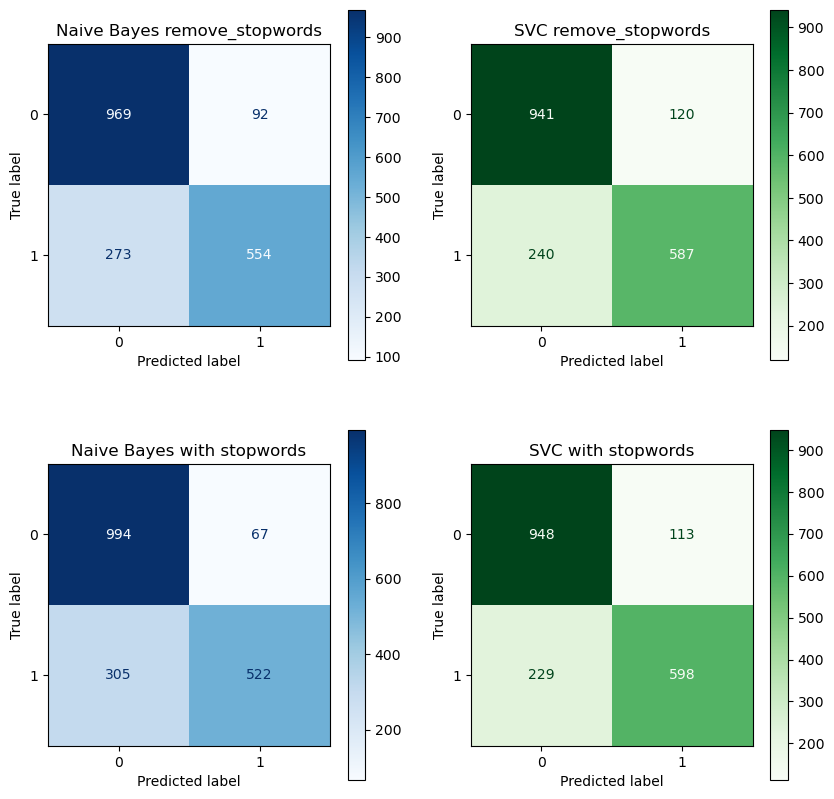

In [28]:
fig, axs = plt.subplots(2,2)
metrics.ConfusionMatrixDisplay.from_predictions(y2_test, pred_m1, display_labels=[0,1], cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_title('Naive Bayes remove_stopwords')
metrics.ConfusionMatrixDisplay.from_predictions(y2_test, pred_m2, display_labels=[0,1], cmap='Greens', ax=axs[0, 1])
axs[0, 1].set_title('SVC remove_stopwords')

metrics.ConfusionMatrixDisplay.from_predictions(y2_test, pred_m3, display_labels=[0,1], cmap='Blues', ax=axs[1, 0])
axs[1, 0].set_title('Naive Bayes with stopwords')
metrics.ConfusionMatrixDisplay.from_predictions(y2_test, pred_m4, display_labels=[0,1], cmap='Greens', ax=axs[1, 1])
axs[1, 1].set_title('SVC with stopwords')

fig.set_figheight(10)
fig.set_figwidth(10)

plt.show()

### Подберем гиперпараметры для SVC

In [49]:
search = GridSearchCV(model_2, param_grid_SVC, n_jobs=2, verbose=1)
search.fit(X1_train, y1_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
grid2 = search.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameter (CV score=0.796):
{'model__C': 21.54434690031882, 'model__degree': 2}


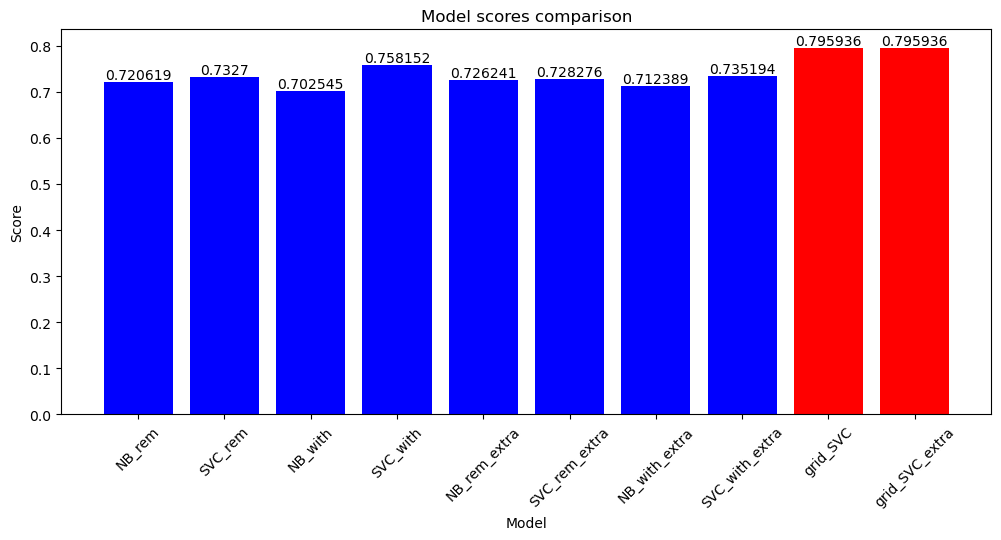

In [63]:
scores = [score1, score2, score3, score4, score1_ws, score2_ws, score3_ws, score4_ws, grid1, grid2]
models = ['NB_rem', 'SVC_rem', 'NB_with', 'SVC_with', 'NB_rem_extra', 'SVC_rem_extra', 'NB_with_extra', 'SVC_with_extra', 'grid_SVC', 'grid_SVC_extra']
colors = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r']
fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(x=models, height=scores, color=colors)
ax.bar_label(bars)
plt.xticks(rotation=45)
plt.title('Model scores comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

### Final

In [189]:
test = pd.read_csv('datasets/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [190]:
test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [191]:
test.fillna(value='', inplace=True)
print(test.isna().sum())
test['new_feature'] = test.keyword + ' ' + test.location + ' ' + test.text
test.head()

id          0
keyword     0
location    0
text        0
dtype: int64


,id,keyword,location,text,new_feature
0,0,,,Just happened a terrible car crash,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities,..."
2,3,,,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese a..."
3,9,,,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan


In [192]:
final_model = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize(x, remove_stopwords=True))),
    ('model', SVC(C=21.5443469, degree=2))
])
final_model.fit(data.new_feature, data.target)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x00000242492F5E50>)),
                ('model', SVC(C=21.5443469, degree=2))])

In [202]:
target = pd.DataFrame(final_model.predict(test.new_feature), columns=['target'])
target.head()

,target
0,1
1,1
2,1
3,1
4,1


In [207]:
result = pd.concat([pd.DataFrame(test.id), target], axis=1)
result.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [210]:
result.to_csv('result.csv', index=False)